In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Dataset
- Download and unzip data from MovieLens 25M: https://grouplens.org/datasets/movielens/

### Installation

In [ ]:
! pip install pandas matplotlib seaborn sklearn polars nltk tqdm implicit

### Data Loading

In [1]:
import polars as pl
import pandas as pd

# Set the display options to show all columns and rows
pl.Config.set_tbl_cols(None)
pl.Config.set_tbl_rows(None)

polars.config.Config

In [4]:
ratings = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ratings.csv')

# Shuffle the data
ratings_shuffled = ratings.sample(frac=1, random_state=42).reset_index(drop=True)
undersample_fraction = 0.10
ratings_undersampled = ratings_shuffled.sample(frac=undersample_fraction, random_state=42).reset_index(drop=True)

# Check the size of the undersampled data
print(f"Original size: {len(ratings)}, Undersampled size: {len(ratings_undersampled)}")

movies = pd.read_csv('/content/drive/My Drive/Colab Notebooks/movies.csv')
tags = pd.read_csv('/content/drive/My Drive/Colab Notebooks/tags.csv')

# Convert to Parquet format
ratings_undersampled.to_parquet('/content/drive/My Drive/Colab Notebooks/ratings.parquet')
movies.to_parquet('/content/drive/My Drive/Colab Notebooks/movies.parquet')
tags.to_parquet('/content/drive/My Drive/Colab Notebooks/tags.parquet')

Original size: 25000095, Undersampled size: 2500010


In [5]:
# Load the datasets using Polars
ratings = pl.read_parquet('/content/drive/My Drive/Colab Notebooks/ratings.parquet')
movies = pl.read_parquet('/content/drive/My Drive/Colab Notebooks/movies.parquet')
tags = pl.read_parquet('/content/drive/My Drive/Colab Notebooks/tags.parquet')

In [6]:
# Convert necessary columns to string
ratings = ratings.with_columns([
    pl.col('userId').cast(pl.Utf8),
    pl.col('movieId').cast(pl.Utf8)
])
movies = movies.with_columns([
    pl.col('movieId').cast(pl.Utf8),
    pl.col('genres').cast(pl.Utf8)
])
tags = tags.with_columns([
    pl.col('userId').cast(pl.Utf8),
    pl.col('movieId').cast(pl.Utf8),
    pl.col('tag').cast(pl.Utf8)
])

In [7]:
# Remove the 'timestamp' column from both DataFrames
# TODO: Utilize timestamp information for sequential recs in future
ratings = ratings.drop('timestamp')
tags = tags.drop('timestamp')

In [8]:
# Extract year using regex and create a new column
movies = movies.with_columns(
    pl.col("title").str.extract(r"\((\d{4})\)$").alias("year")
)

# Remove year from title
movies = movies.with_columns(
    pl.col("title").str.replace(r"\s\(\d{4}\)$", "").alias("clean_title")
)

movies = movies.drop("title")
movies = movies.rename({"clean_title": "title"})

### EDA

In [40]:
#looking for some initial statistics of data
print('No of Users who rated movies:', ratings['userId'].n_unique())
print('No of Movies:', ratings['movieId'].n_unique())
print('No of ratings:', ratings['rating'].count())
print('No of user comments:', tags['tag'].n_unique())
print('No of Movies commented by user:', tags['movieId'].n_unique())
print('Percentage of user commented:', (tags['tag'].n_unique()/ratings['userId'].n_unique())*100, '%')
print('No of movies commented by user:', (ratings['movieId'].n_unique()/ratings['movieId'].n_unique())*100, '%')

No of Users who rated movies: 159376
No of Movies: 31919
No of ratings: 2500010
No of user comments: 73051
No of Movies commented by user: 45251
Percentage of user commented: 45.83563397249272 %
No of movies commented by user: 100.0 %


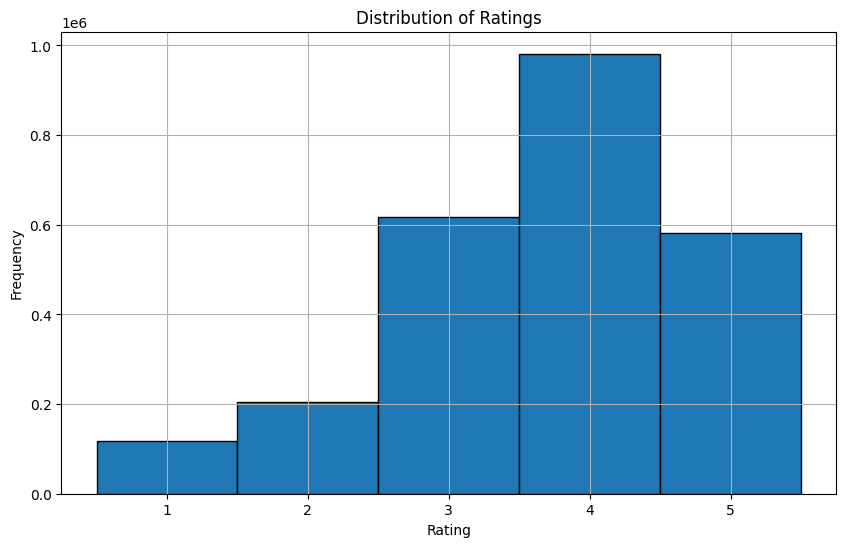

In [22]:
import matplotlib.pyplot as plt

# Plot distribution of ratings
plt.figure(figsize=(10, 6))
ratings_pd['rating'].hist(bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks([1, 2, 3, 4, 5])
plt.show()

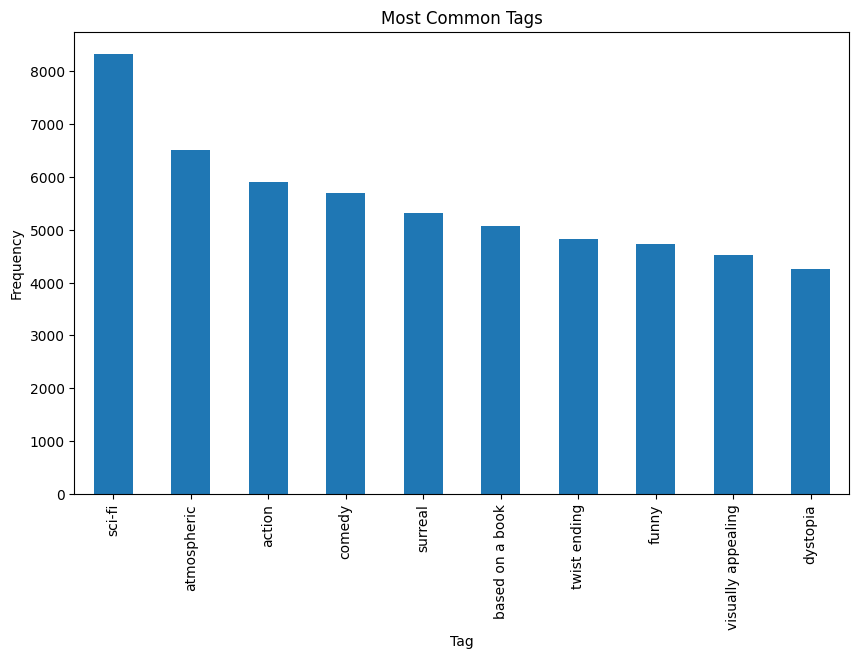

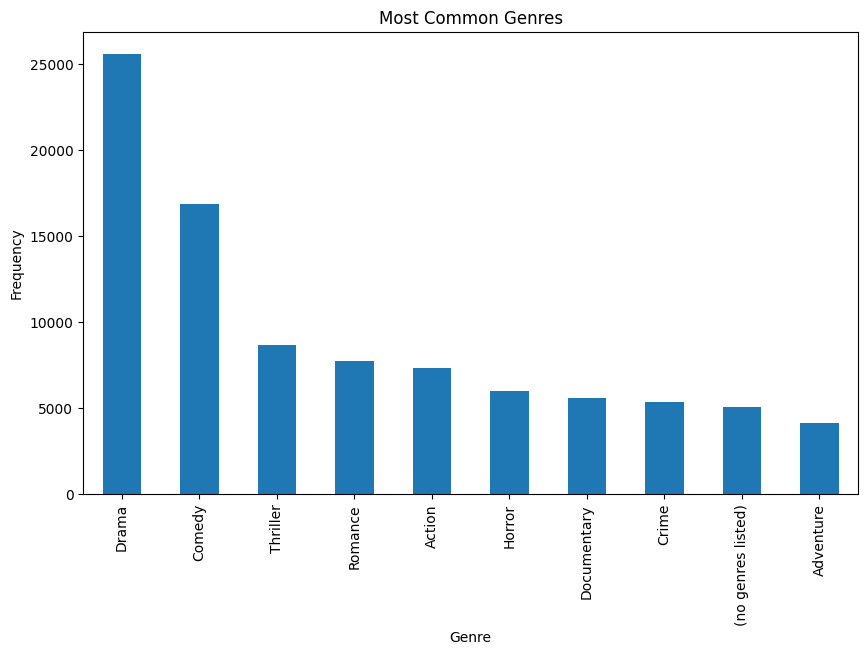

In [17]:
# Commonly used tags and genres

# Assuming 'tags' and 'movies' are Polars dataframes, convert them to Pandas
tags_pd = tags.to_pandas()
movies_pd = movies.to_pandas()

# Most common tags
common_tags = tags_pd['tag'].value_counts().head(10)

# Plot most common tags
plt.figure(figsize=(10, 6))
common_tags.plot(kind='bar')
plt.title('Most Common Tags')
plt.xlabel('Tag')
plt.ylabel('Frequency')
plt.show()

# Extract genres and count their occurrences
movies_pd['genres'] = movies_pd['genres'].str.split('|')
all_genres = [genre for sublist in movies_pd['genres'].tolist() for genre in sublist]
common_genres = pd.Series(all_genres).value_counts().head(10)

# Plot most common genres
plt.figure(figsize=(10, 6))
common_genres.plot(kind='bar')
plt.title('Most Common Genres')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.show()

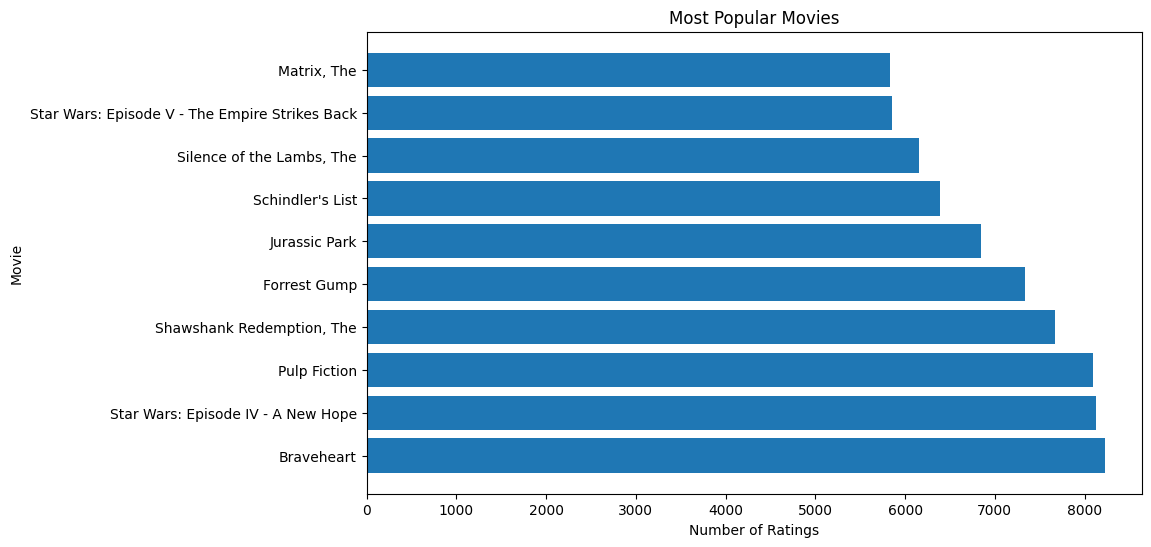

In [20]:
# popular movies and genres
# Count number of ratings per movie
ratings_pd = ratings.to_pandas()

movie_ratings_count = ratings_pd['movieId'].value_counts().head(10)

# Get movie titles
popular_movies = movies_pd[movies_pd['movieId'].isin(movie_ratings_count.index)]

# Plot most popular movies
plt.figure(figsize=(10, 6))
plt.barh(popular_movies['title'], movie_ratings_count)
plt.title('Most Popular Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie')
plt.show()

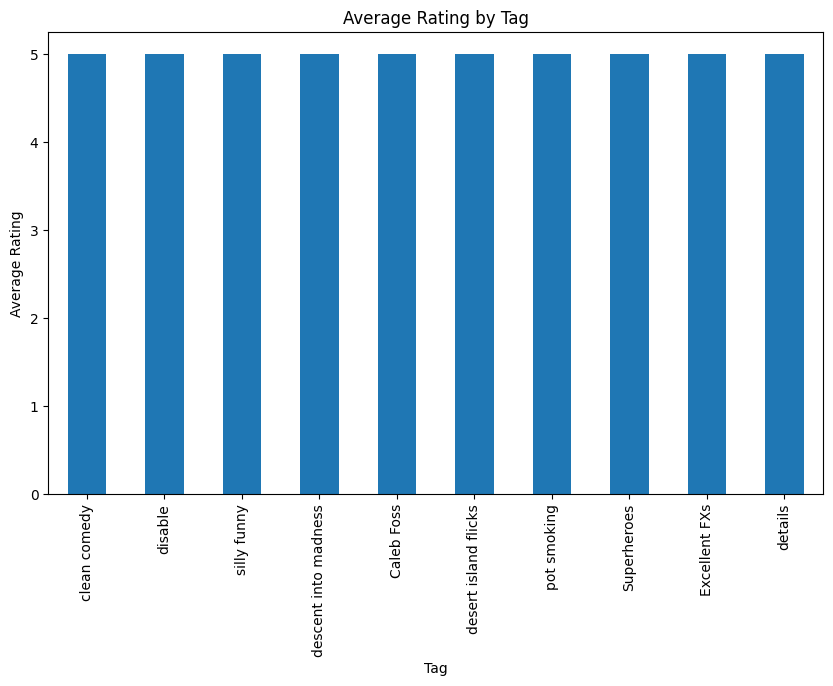

Correlation between tag usage and average ratings: 0.059584115891502615


In [21]:
# Tag usage trends
# Merge tags with ratings
tagged_ratings = pd.merge(tags_pd, ratings_pd, on=['userId', 'movieId'], how='inner')

# Count tag occurrences and their average ratings
tag_avg_ratings = tagged_ratings.groupby('tag')['rating'].mean().sort_values(ascending=False).head(10)

# Plot tag usage trends
plt.figure(figsize=(10, 6))
tag_avg_ratings.plot(kind='bar')
plt.title('Average Rating by Tag')
plt.xlabel('Tag')
plt.ylabel('Average Rating')
plt.show()

# Correlation between tag usage and ratings
tag_ratings_count = tagged_ratings['tag'].value_counts()
tag_correlation = tagged_ratings.groupby('tag')['rating'].mean().corr(tag_ratings_count)

print(f"Correlation between tag usage and average ratings: {tag_correlation}")

In [9]:
genres_list = []
for row in movies.iter_rows():
    genres = row[1]
    try:
        genres = genres.split('|')
        genres_list.extend(genres)
    except:
        genres_list.append(row.genres)
genres_list = list(set(genres_list))

In [ ]:
genres_list

['Sci-Fi',
 'Children',
 'Adventure',
 'Drama',
 'Musical',
 'War',
 'Action',
 'Crime',
 'Fantasy',
 'Animation',
 '(no genres listed)',
 'Western',
 'Comedy',
 'Romance',
 'Horror',
 'Film-Noir',
 'Thriller',
 'Mystery',
 'IMAX',
 'Documentary']

In [41]:
avg_ratings_by_movies = ratings.group_by("movieId").agg([
    pl.col("rating").mean().alias("avg_rating"),
    pl.col("rating").count().alias("count")
])

avg_ratings_by_movies.describe()

describe,movieId,avg_rating,count
str,str,f64,f64
"""count""","""31919""",31919.0,31919.0
"""null_count""","""0""",0.0,0.0
"""mean""",null,3.14961,78.323569
"""std""",null,0.839586,332.928463
"""min""","""1""",0.5,1.0
"""25%""",null,2.75,1.0
"""50%""",null,3.25,3.0
"""75%""",null,3.673197,20.0
"""max""","""99996""",5.0,8225.0


In [42]:
# Filter movies with more than 10,000 ratings
filtered_movies = avg_ratings_by_movies.filter(pl.col("count") > 10000)

# Find the movie with the higher average rating
highest_rated_movie = filtered_movies.sort("avg_rating", descending=True).head(20)

# Join with movies DataFrame to get the title
highest_rated_movie_with_title = highest_rated_movie.join(movies, on="movieId", how="left")

# Select relevant columns
highest_rated_movie_with_title = highest_rated_movie_with_title.select(["movieId", "title", "avg_rating", "count"])

highest_rated_movie_with_title

movieId,title,avg_rating,count
str,str,f64,u32


In [43]:
# Group by userId and aggregate
avg_ratings_by_user = ratings.group_by("userId").agg([
    pl.col("rating").mean().alias("avg_rating"),
    pl.col("rating").count().alias("count")
])

avg_ratings_by_user.describe()

describe,userId,avg_rating,count
str,str,f64,f64
"""count""","""159376""",159376.0,159376.0
"""null_count""","""0""",0.0,0.0
"""mean""",null,3.679175,15.686239
"""std""",null,0.643026,27.247537
"""min""","""1""",0.5,1.0
"""25%""",null,3.320261,4.0
"""50%""",null,3.714286,7.0
"""75%""",null,4.071429,17.0
"""max""","""99999""",5.0,3285.0


In [44]:
user_tag_count = tags.group_by('userId').agg(pl.col('tag').count().alias('tag_count'))
user_tag_count.max()

userId,tag_count
str,u32
"""99988""",183356


In [45]:
movie_tag_count = tags.group_by('movieId').agg(pl.col('tag').count().alias('tag_count'))

movie_tag_count.max()

movieId,tag_count
str,u32
"""99999""",6180


In [46]:
# Split the genres column into multiple rows
movies_exploded = movies.with_columns(pl.col('genres').str.split('|')).explode('genres')

# Get a list of unique genres
unique_genres = movies_exploded.select(pl.col('genres')).unique().to_series().to_list()

# Create a one-hot encoding for each genre
for genre in unique_genres:
    movies_exploded = movies_exploded.with_columns(
        (pl.col('genres') == genre).alias(f'{genre}')
    )

# Pivot the DataFrame to get one row per movie with genre columns
genres_one_hot = movies_exploded.group_by('movieId').agg(
    [pl.max(f'{genre}') for genre in unique_genres]
)

Number of movies with year 0: 566


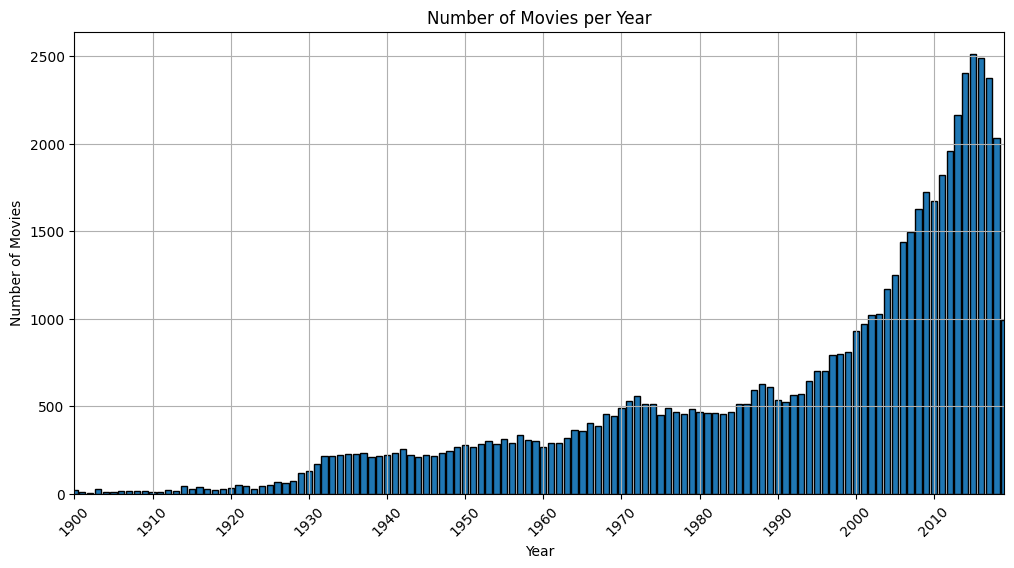

In [16]:
import matplotlib.pyplot as plt
import polars as pl

# Number of movies per year
movies_per_year = movies.group_by('year').agg(pl.count('movieId').alias('movie_count'))
movies_per_year = movies_per_year.with_columns(
    pl.col('year').fill_null(0)
)

# Convert to pandas DataFrame
movies_per_year_pd = movies_per_year.to_pandas()

# Ensure the 'year' column is in integer format
movies_per_year_pd['year'] = movies_per_year_pd['year'].astype(int)

# Count the number of movies with year 0
year_zero_count = movies_per_year_pd[movies_per_year_pd['year'] == 0]['movie_count'].sum()
print(f'Number of movies with year 0: {year_zero_count}')

# Filter out the year 0 data
movies_per_year_pd = movies_per_year_pd[movies_per_year_pd['year'] != 0]

# Create a DataFrame with all years from 1900 to the current year
all_years = pd.DataFrame({'year': range(1900, movies_per_year_pd['year'].max() + 1)})

# Merge with movies_per_year_pd to fill in missing years with 0 movie count
movies_per_year_pd = all_years.merge(movies_per_year_pd, on='year', how='left').fillna(0)

# Convert movie_count to int
movies_per_year_pd['movie_count'] = movies_per_year_pd['movie_count'].astype(int)

# Plot histogram
plt.figure(figsize=(12, 6))
plt.bar(movies_per_year_pd['year'], movies_per_year_pd['movie_count'], edgecolor='black')
plt.xlim(1900, movies_per_year_pd['year'].max())

# Custom x-ticks: from 1900 onwards
xticks = list(range(1900, movies_per_year_pd['year'].max() + 1, 10))
plt.xticks(xticks, rotation=45)

plt.title('Number of Movies per Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.show()

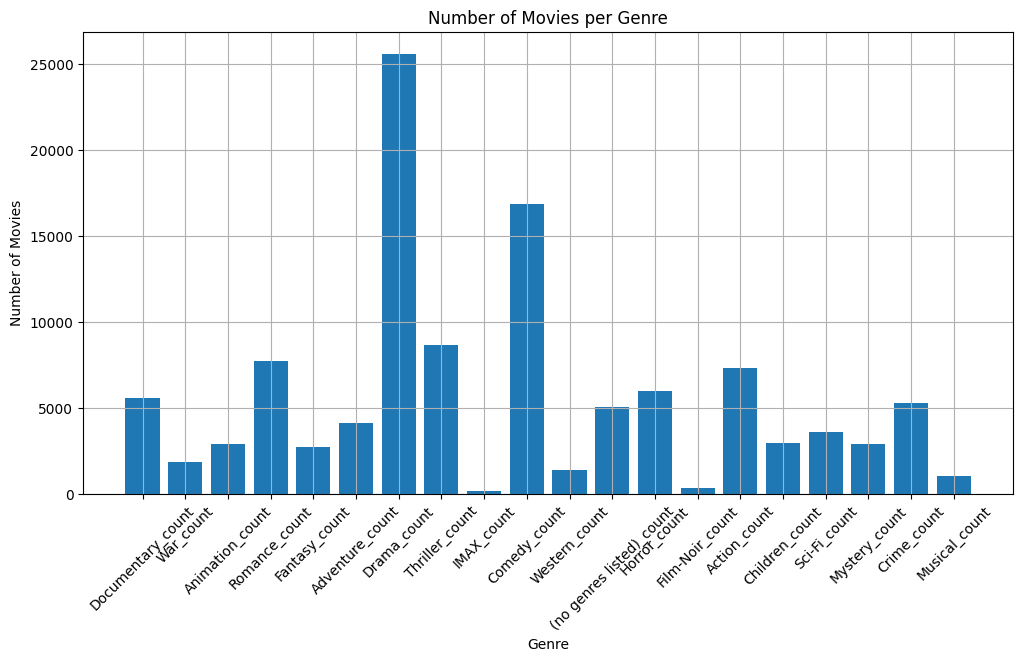

In [17]:
# Plot number of movies per genre
genres_columns = genres_one_hot.columns
genres_columns.remove('movieId')  # Remove movieId from genre columns

movies_per_genre = genres_one_hot.select(
    [pl.sum(col).alias(f'{col}_count') for col in genres_columns]
)
movies_per_genre_pd = movies_per_genre.to_pandas()

movies_per_genre_pd = movies_per_genre_pd.T  # Transpose for easier plotting
movies_per_genre_pd.columns = ['count']
movies_per_genre_pd = movies_per_genre_pd.reset_index().rename(columns={'index': 'genre'})

plt.figure(figsize=(12, 6))
plt.bar(movies_per_genre_pd['genre'], movies_per_genre_pd['count'])
plt.title('Number of Movies per Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [47]:
# Movies per genre
# Assuming genres_one_hot has binary columns for each genre
genres_columns = genres_one_hot.columns
genres_columns.remove('movieId')  # Remove movieId from genre columns

movies_per_genre = genres_one_hot.select(
    [pl.sum(col).alias(f'{col}_count') for col in genres_columns]
)

movies_per_genre

Film-Noir_count,Fantasy_count,War_count,Adventure_count,Romance_count,Horror_count,Action_count,Comedy_count,Children_count,Mystery_count,(no genres listed)_count,Animation_count,Crime_count,Drama_count,Western_count,IMAX_count,Documentary_count,Thriller_count,Sci-Fi_count,Musical_count
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
353,2731,1874,4145,7719,5989,7348,16870,2935,2925,5062,2929,5319,25606,1399,195,5605,8654,3595,1054


In [48]:
import re
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to clean and normalize tags
def clean_normalize_tag(tag):
    # Convert to lowercase
    tag = tag.lower()
    # Remove special characters
    tag = re.sub(r'[^a-zA-Z\s]', '', tag)
    # Tokenize and lemmatize
    tokens = word_tokenize(tag)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Rejoin tokens
    cleaned_tag = ' '.join(lemmatized_tokens)
    return cleaned_tag

# Apply the function to the 'tag' column
tags = tags.with_columns(tags['tag'].map_elements(clean_normalize_tag).alias('cleaned_tag'))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [49]:
# Group by 'tag' and count the number of unique 'movieId' for each tag
tag_counts = tags.group_by('tag').agg(pl.col('movieId').n_unique().alias('unique_movie_count'))

# Filter tags that appear in more than 50 unique movies
tags_to_keep = tag_counts.filter(pl.col('unique_movie_count') > 50)

# Join the original tags DataFrame with tags_to_keep to filter rows
filtered_tags = tags.join(tags_to_keep, on='tag', how='inner')

# Drop the original 'tag' column
filtered_tags = filtered_tags.drop('tag')

# Rename 'cleaned_tag' to 'tag'
tags = filtered_tags.rename({'cleaned_tag': 'tag'})

In [50]:
# Merge ratings with movies
data = ratings.join(movies.drop('genres'), on='movieId', how='left')

# Merge one-hot encoded genres with the main data
data = data.join(genres_one_hot, on='movieId', how='left')

# Merge the tags data with the main dataset
data_with_tags = data.join(tags, on=['userId', 'movieId'], how='left')

# Merge average ratings by movie
avg_ratings_by_movies = avg_ratings_by_movies.rename({"avg_rating": "avg_movie_rating", "count": "movie_rating_count"})
data_with_avg_movie_rating = data_with_tags.join(avg_ratings_by_movies, on='movieId', how='left')

# Merge average ratings by user
avg_ratings_by_user = avg_ratings_by_user.rename({"avg_rating": "avg_user_rating", "count": "user_rating_count"})
final_data = data_with_avg_movie_rating.join(avg_ratings_by_user, on='userId', how='left')

In [51]:
# Fill missing tag values with an empty string
data_with_tags = final_data.with_columns(
    pl.col('tag').fill_null('')
)

# Convert Polars DataFrame to Pandas DataFrame for further processing
data_with_tags = data_with_tags.to_pandas()

In [52]:
# Normalize ratings to the range [0, 1]
min_rating = data_with_tags['rating'].min()
max_rating = data_with_tags['rating'].max()

data_with_tags['rating_normalized'] = (data_with_tags['rating'] - min_rating) / (max_rating - min_rating)

In [53]:
data_with_tags.to_parquet('/content/drive/My Drive/Colab Notebooks/data_with_tags.parquet')

In [54]:
data_with_tags = pd.read_parquet('/content/drive/My Drive/Colab Notebooks/data_with_tags.parquet')

In [55]:
from sklearn.preprocessing import LabelEncoder
from transformers import BertModel, BertTokenizer
from transformers import DistilBertModel, DistilBertTokenizer

import torch
import torch.nn as nn
import torch.optim as optim
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# # Use BERT for tag embeddings
# # tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# # bert_model = BertModel.from_pretrained('bert-base-uncased')

# # Use DistilBERT for tag embeddings
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# # Function to process tags in batches
# def get_tag_embeddings(tags, batch_size=2):
#     all_embeddings = []
#     for i in range(0, len(tags), batch_size):
#         batch_tags = tags[i:i + batch_size]
#         tokens = tokenizer(batch_tags, padding=True, truncation=True, return_tensors="pt")
#         with torch.no_grad():
#             batch_embeddings = bert_model(**tokens).last_hidden_state.mean(dim=1)
#             all_embeddings.append(batch_embeddings)
#     return torch.cat(all_embeddings)

# # Process tags in batches to avoid OOM
# tags = list(data_with_tags['tag'])
# tag_embeddings = get_tag_embeddings(tags, batch_size=2)

In [56]:
# Instantiate user and movie embeddings
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

user_embedding = nn.Embedding(data_with_tags['userId'].nunique(), 50)
movie_embedding = nn.Embedding(data_with_tags['movieId'].nunique(), 50)

data_with_tags['userId'] = user_encoder.fit_transform(data_with_tags['userId'])
data_with_tags['movieId'] = movie_encoder.fit_transform(data_with_tags['movieId'])

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine tags for each movie
data_with_tags['tags_combined'] = data_with_tags.groupby('movieId')['tag'].transform(lambda x: ' '.join(x))
# Calculate TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(max_features=50)  # Limit to top 50 features for simplicity
tfidf_matrix = tfidf_vectorizer.fit_transform(data_with_tags['tags_combined'])

# Convert TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Merge TF-IDF vectors with the data
data_with_tags = data_with_tags.reset_index().merge(tfidf_df.reset_index(), left_index=True, right_index=True).drop('tags_combined', axis=1)

In [58]:
data_with_tags.to_parquet('/content/drive/My Drive/Colab Notebooks/data_with_tf_tags.parquet')

In [7]:
data_with_tags = pd.read_parquet('/content/drive/My Drive/Colab Notebooks/data_with_tf_tags.parquet')

In [59]:
from sklearn.model_selection import train_test_split

from transformers import BertModel, BertTokenizer
from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, ndcg_score, precision_score

import matplotlib.pyplot as plt
from tqdm import tqdm

In [60]:
class MovieLensDataset(Dataset):
    def __init__(self, data, tfidf_matrix):
        self.users = data['userId'].values
        self.movies = data['movieId'].values
        self.ratings = data['rating_normalized'].values
        self.tag_embeddings = tfidf_matrix

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        user = self.users[idx]
        movie = self.movies[idx]
        rating = self.ratings[idx]
        tag_embedding = torch.tensor(self.tag_embeddings[idx], dtype=torch.float32)

        return (
            torch.tensor(user, dtype=torch.long),
            torch.tensor(movie, dtype=torch.long),
            tag_embedding,
            torch.tensor(rating, dtype=torch.float32)
        )

# Split data
train_data, test_data = train_test_split(data_with_tags, test_size=0.2, random_state=42)

# Create train and test datasets
train_tfidf_matrix = tfidf_matrix[train_data.index]
test_tfidf_matrix = tfidf_matrix[test_data.index]

train_dataset = MovieLensDataset(train_data, train_tfidf_matrix.toarray())
test_dataset = MovieLensDataset(test_data, test_tfidf_matrix.toarray())

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [61]:
class TransformerRecommender(nn.Module):
    def __init__(self, user_embedding, movie_embedding, tag_dim):
        super(TransformerRecommender, self).__init__()
        self.user_embedding = user_embedding
        self.movie_embedding = movie_embedding
        self.fc1 = nn.Linear(100 + tag_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, user, movie, tag_embedding):
        user_emb = self.user_embedding(user)
        movie_emb = self.movie_embedding(movie)
        x = torch.cat([user_emb, movie_emb, tag_embedding], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        rating = self.fc3(x)
        return rating

# Instantiate the transformer model
tag_dim = tfidf_matrix.shape[1]
transformer_model = TransformerRecommender(user_embedding, movie_embedding, tag_dim)

# Define optimizer and criterion for transformer model
criterion_transformer = nn.MSELoss()
optimizer_transformer = optim.Adam(transformer_model.parameters(), lr=0.001)


In [62]:
class MatrixFactorizationNN(nn.Module):
    def __init__(self, user_embedding, movie_embedding, tag_dim):
        super(MatrixFactorizationNN, self).__init__()
        self.user_embedding = user_embedding
        self.movie_embedding = movie_embedding
        self.fc1 = nn.Linear(50 * 2 + tag_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, user, movie, tag_embedding):
        user_emb = self.user_embedding(user)
        movie_emb = self.movie_embedding(movie)
        x = torch.cat([user_emb, movie_emb, tag_embedding], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        rating = self.fc3(x)
        return rating

# Instantiate the model with tag dimension
tag_dim = tfidf_matrix.shape[1]
model_mf_nn = MatrixFactorizationNN(user_embedding, movie_embedding, tag_dim)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer_mf = optim.Adam(model_mf_nn.parameters(), lr=0.001)

In [63]:
class DeepNCF(nn.Module):
    def __init__(self, user_embedding, movie_embedding, tag_dim):
        super(DeepNCF, self).__init__()
        self.user_embedding = user_embedding
        self.movie_embedding = movie_embedding
        self.fc1 = nn.Linear(50 * 2 + tag_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, user, movie, tag_embedding):
        user_emb = self.user_embedding(user)
        movie_emb = self.movie_embedding(movie)
        x = torch.cat([user_emb, movie_emb, tag_embedding], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        rating = self.fc3(x)
        return rating

# Instantiate the model with tag dimension
tag_dim = tfidf_matrix.shape[1]
model_deep_ncf = DeepNCF(user_embedding, movie_embedding, tag_dim)

# Loss and optimizer
criterion_deep_ncf = nn.MSELoss()
optimizer_deep_ncf = optim.Adam(model_deep_ncf.parameters(), lr=0.001)

In [64]:
class CFNN(nn.Module):
    def __init__(self, user_embedding, movie_embedding, tag_dim):
        super(CFNN, self).__init__()
        self.user_embedding = user_embedding
        self.movie_embedding = movie_embedding
        self.fc1 = nn.Linear(50 * 2 + tag_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, user, movie, tag_embedding):
        user_emb = self.user_embedding(user)
        movie_emb = self.movie_embedding(movie)
        x = torch.cat([user_emb, movie_emb, tag_embedding], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        rating = self.fc3(x)
        return rating

# Instantiate the model with tag dimension
tag_dim = tfidf_matrix.shape[1]
model_cf_nn = CFNN(user_embedding, movie_embedding, tag_dim)

# Loss and optimizer
criterion_cf_nn = nn.MSELoss()
optimizer_cf_nn = optim.Adam(model_cf_nn.parameters(), lr=0.001)

In [65]:
class UserTower(nn.Module):
    def __init__(self, num_users, embedding_dim):
        super(UserTower, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, 128)
        self.fc2 = nn.Linear(128, embedding_dim)

    def forward(self, user):
        user_emb = self.user_embedding(user)
        x = torch.relu(self.fc1(user_emb))
        user_embedding = self.fc2(x)
        return user_embedding

class ItemTower(nn.Module):
    def __init__(self, num_items, embedding_dim):
        super(ItemTower, self).__init__()
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, 128)
        self.fc2 = nn.Linear(128, embedding_dim)

    def forward(self, item):
        item_emb = self.item_embedding(item)
        x = torch.relu(self.fc1(item_emb))
        item_embedding = self.fc2(x)
        return item_embedding

# Candidate Retrieval
class CandidateRetrievalModel(nn.Module):
    def __init__(self, user_tower, item_tower):
        super(CandidateRetrievalModel, self).__init__()
        self.user_tower = user_tower
        self.item_tower = item_tower

    def forward(self, user, item):
        user_embedding = self.user_tower(user)
        item_embedding = self.item_tower(item)
        score = torch.sum(user_embedding * item_embedding, dim=1)  # Dot product
        return score

# Hyperparameters
embedding_dim = 50
tag_dim = tfidf_matrix.shape[1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate user and item towers
user_tower = UserTower(data_with_tags['userId'].nunique(), embedding_dim).to(device)
item_tower = ItemTower(data_with_tags['movieId'].nunique(), embedding_dim).to(device)

# Instantiate candidate retrieval model
candidate_model = CandidateRetrievalModel(user_tower, item_tower).to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(candidate_model.parameters(), lr=0.001)

# Ranking Model
class RankingModel(nn.Module):
    def __init__(self, user_embedding_dim, item_embedding_dim, tag_dim):
        super(RankingModel, self).__init__()
        self.fc1 = nn.Linear(user_embedding_dim + item_embedding_dim + tag_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, user_embedding, item_embedding, tag_embedding):
        x = torch.cat([user_embedding, item_embedding, tag_embedding], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        rating = self.fc3(x)
        return rating

# Instantiate ranking model
ranking_model = RankingModel(embedding_dim, embedding_dim, tag_dim).to(device)

# Loss and optimizer for ranking model
criterion_ranking = nn.MSELoss().to(device)
optimizer_ranking = optim.Adam(ranking_model.parameters(), lr=0.001)

def retrieve_candidates(user_id, candidate_model, all_movie_ids, top_k=100):
    user_tensor = torch.tensor([user_id] * len(all_movie_ids)).to(device)
    movie_tensor = torch.tensor(all_movie_ids).to(device)
    candidate_model.eval()
    with torch.no_grad():
        scores = candidate_model(user_tensor, movie_tensor)
    top_k_indices = torch.topk(scores, top_k).indices.cpu().numpy()
    top_k_movie_ids = [all_movie_ids[i] for i in top_k_indices]
    return top_k_movie_ids


def rank_candidates(ranking_model, user_id, candidates, tag_embeddings, device):
    user_tensor = torch.tensor([user_id] * len(candidates), dtype=torch.long).to(device)
    movie_tensor = torch.tensor(candidates, dtype=torch.long).to(device)
    tag_embeddings_tensor = torch.tensor(tag_embeddings[candidates], dtype=torch.float32).to(device)  # Convert numpy array to tensor

    user_embedding = user_tower(user_tensor).to(torch.float32).to(device)
    movie_embedding = item_tower(movie_tensor).to(torch.float32).to(device)

    # Pass the embeddings separately to the RankingModel
    scores = ranking_model(user_embedding, movie_embedding, tag_embeddings_tensor)

    ranked_indices = torch.argsort(scores, descending=True).cpu().numpy()
    ranked_candidates = [candidates[int(i)] for i in ranked_indices]  # Convert indices to integers
    return ranked_candidates

def get_top_n_recommendations_two_tower(user_id, candidate_model, ranking_model, all_movie_ids, tag_embeddings, N, device):
    top_k_candidates = retrieve_candidates(user_id, candidate_model, all_movie_ids, top_k=100)
    ranked_candidates = rank_candidates(ranking_model, user_id, top_k_candidates, tag_embeddings, device)
    return ranked_candidates[:N]

In [66]:
class TwoTowerRecommendationService:
    def __init__(self, candidate_model, ranking_model, user_tower, item_tower, data, tag_embeddings, device):
        self.candidate_model = candidate_model
        self.ranking_model = ranking_model
        self.user_tower = user_tower
        self.item_tower = item_tower
        self.data = data
        self.all_movie_ids = data['movieId'].unique()
        self.tag_embeddings = tag_embeddings
        self.device = device

    def recommend(self, user_id, N):
        top_n_movie_ids = get_top_n_recommendations_two_tower(
            user_id, self.candidate_model, self.ranking_model, self.all_movie_ids, self.tag_embeddings, N, self.device
        )
        return top_n_movie_ids


In [67]:
def train(model, loader, criterion, optimizer, device):
    model.train()
    train_loss = 0
    for batch in tqdm(loader):
        user, movie, tag_embedding, rating = batch
        user, movie, tag_embedding, rating = user.to(device), movie.to(device), tag_embedding.to(device), rating.to(device)
        optimizer.zero_grad()
        outputs = model(user, movie, tag_embedding)
        loss = criterion(outputs, rating.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(loader)

def evaluate_two_tower_model(recommendation_service, test_data, N):
    all_targets = []
    all_preds = []
    recalls = []
    precisions = []
    ndcgs = []
    maps = []

    for user_id in test_data['userId'].unique():
        user_test_data = test_data[test_data['userId'] == user_id]
        true_movie_ids = user_test_data['movieId'].tolist()
        pred_movie_ids = recommendation_service.recommend(user_id, N)

        # Create binary relevance scores for NDCG and precision calculation
        relevance = [1 if movie_id in true_movie_ids else 0 for movie_id in pred_movie_ids]

        # Ensure consistent lengths for all_targets and all_preds
        target_length = min(len(true_movie_ids), N)
        all_targets.extend([1] * target_length + [0] * (N - target_length))
        all_preds.extend(relevance[:N])


    # Binarize all_preds for classification metrics
    binary_all_preds = np.round(all_preds).astype(int)
    binary_all_targets = np.array(all_targets).astype(int)

    print(f"Evaluating {model_name}")
    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    ndcg = ndcg_score([binary_all_targets], [binary_all_preds])
    precision = precision_score(binary_all_targets, binary_all_preds, average='micro', zero_division=0)
    recall = recall_score(binary_all_targets, binary_all_preds, average='micro', zero_division=0)

    return mse, mae, ndcg, precision, recall

def evaluate(model, loader, criterion, device, max_rating, min_rating):
    model.eval()
    eval_loss = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in loader:
            user, movie, tag_embedding, rating = batch
            user, movie, tag_embedding, rating = user.to(device), movie.to(device), tag_embedding.to(device), rating.to(device)
            outputs = model(user, movie, tag_embedding)
            loss = criterion(outputs, rating.unsqueeze(1))
            eval_loss += loss.item()
            # Scale predictions back to original rating range
            outputs = outputs.squeeze().cpu().numpy() * (max_rating - min_rating) + min_rating
            all_preds.extend(outputs)
            all_targets.extend(rating.cpu().numpy() * (max_rating - min_rating) + min_rating)
    return eval_loss / len(loader), all_preds, all_targets


In [68]:
import os
def save_model_checkpoint(model, model_name):
    os.makedirs('/content/drive/My Drive/Colab Notebooks/checkpoints', exist_ok=True)
    torch.save(model.state_dict(), f'/content/drive/My Drive/Colab Notebooks/checkpoints/{model_name}.pth')

def load_model_checkpoint(model, model_name):
    model.load_state_dict(torch.load(f'/content/drive/My Drive/Colab Notebooks/checkpoints/{model_name}.pth'))
    return model

In [73]:
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

models = {
    'TransformerRecommender': (transformer_model, criterion_transformer, optimizer_transformer),
    'MatrixFactorizationNN': (model_mf_nn, criterion, optimizer_mf),
    'DeepNCF': (model_deep_ncf, criterion, optimizer_deep_ncf),
    'CFNN': (model_cf_nn, criterion, optimizer_cf_nn),
    'TwoTowerModel': (candidate_model, None, None)
}

# Define dictionaries to store metrics
train_loss_history = {model_name: [] for model_name in models.keys()}
eval_loss_history = {model_name: [] for model_name in models.keys()}
mse_history = {model_name: [] for model_name in models.keys()}
mae_history = {model_name: [] for model_name in models.keys()}
ndcg_history = {model_name: [] for model_name in models.keys()}
precision_history = {model_name: [] for model_name in models.keys()}
recall_history = {model_name: [] for model_name in models.keys()}
map_history = {model_name: [] for model_name in models.keys()}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10  # Reduce the number of epochs for quick testing

for model_name, (model, criterion, optimizer) in models.items():
    if model_name == 'TwoTowerModel':
        # Skip training for two-tower model as it's already trained
        print(f"Evaluating {model_name}")
        N = 10  # Number of recommendations to evaluate
        recommendation_service = TwoTowerRecommendationService(candidate_model,
                                                               ranking_model,
                                                               user_tower,
                                                               item_tower,
                                                               data_with_tags,
                                                               tfidf_matrix.toarray(), device)
        mse, mae, ndcg, precision, recall = evaluate_two_tower_model(recommendation_service, test_data, N)

        # Store the metrics
        mse_history[model_name].append(mse)
        mae_history[model_name].append(mae)
        ndcg_history[model_name].append(ndcg)
        precision_history[model_name].append(precision)
        recall_history[model_name].append(recall)
    else:
        print(f"Training {model_name}")
        model.to(device)
        for epoch in range(num_epochs):
            train_loss = train(model, train_loader, criterion, optimizer, device)
            eval_loss, all_preds, all_targets = evaluate(model, test_loader, criterion, device, max_rating, min_rating)
            print(f"Model: {model_name}, Epoch {epoch+1}, Train Loss: {train_loss}, Eval Loss: {eval_loss}")

            # Store the metrics
            train_loss_history[model_name].append(train_loss)
            eval_loss_history[model_name].append(eval_loss)

            # Binarize all_preds for classification metrics
            binary_all_preds = np.round(all_preds).astype(int)
            binary_all_targets = np.array(all_targets).astype(int)

            mse = mean_squared_error(all_targets, all_preds)
            mae = mean_absolute_error(all_targets, all_preds)
            ndcg = ndcg_score([binary_all_targets], [binary_all_preds])
            precision = precision_score(binary_all_targets, binary_all_preds, average='micro', zero_division=0)
            recall = recall_score(binary_all_targets, binary_all_preds, average='micro', zero_division=0)

            mse_history[model_name].append(mse)
            mae_history[model_name].append(mae)
            ndcg_history[model_name].append(ndcg)
            precision_history[model_name].append(precision)
            recall_history[model_name].append(recall)

    print(f"{model_name} - MSE: {mse}, MAE: {mae}, NDCG: {ndcg}, Precision: {precision}, Recall: {recall}")

Evaluating TwoTowerModel


<ipython-input-65-143581305724>:102: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ranked_candidates = [candidates[int(i)] for i in ranked_indices]  # Convert indices to integers


Evaluating TwoTowerModel
TwoTowerModel - MSE: 0.3479280998294524, MAE: 0.3479280998294524, NDCG: 0.9174421989659926, Precision: 0.6520719001705476, Recall: 0.6520719001705476


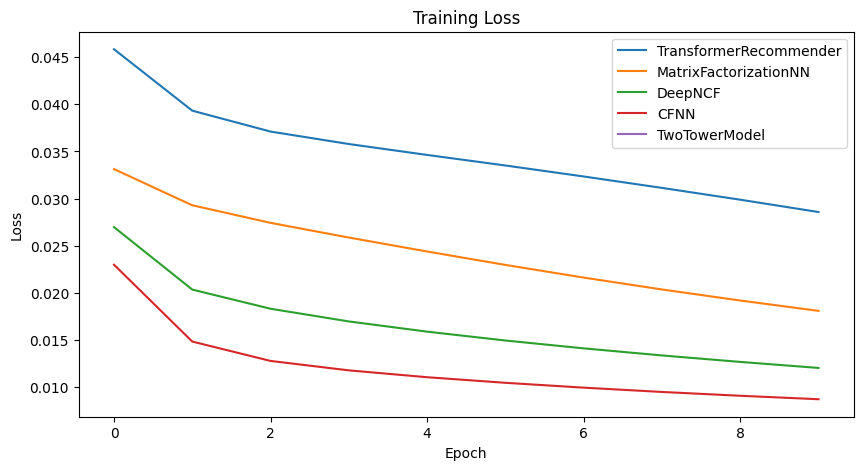

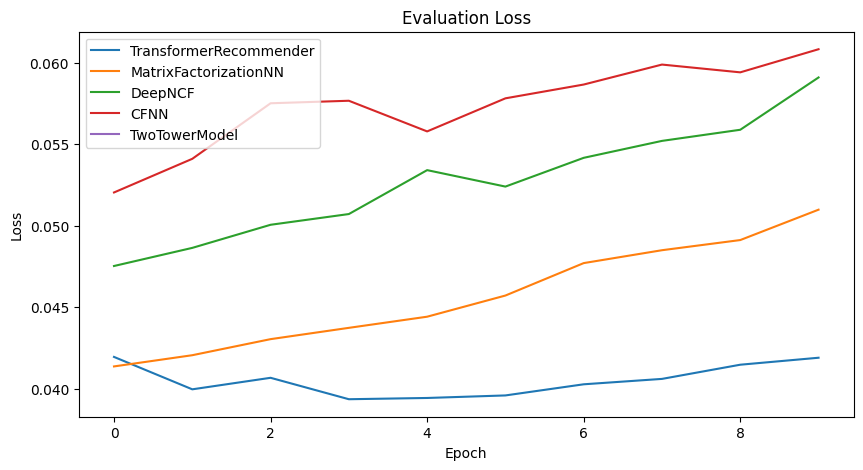

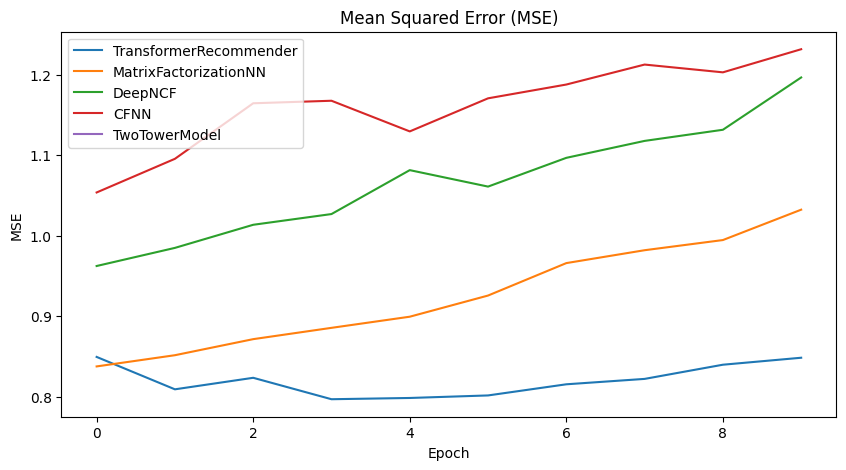

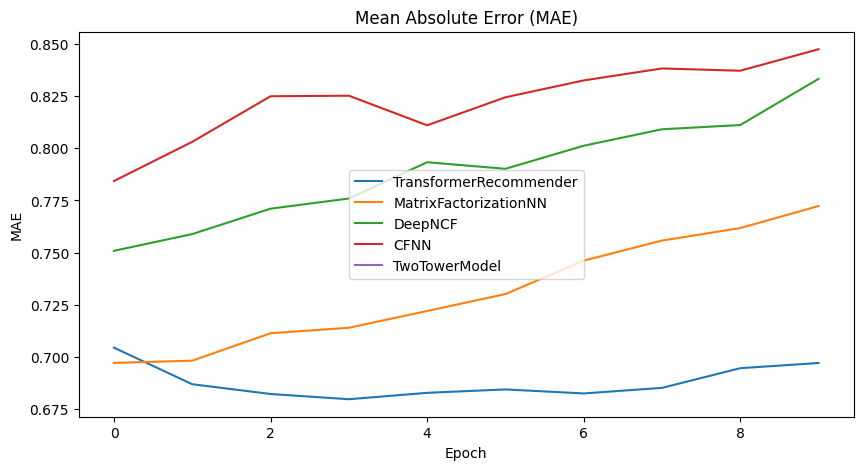

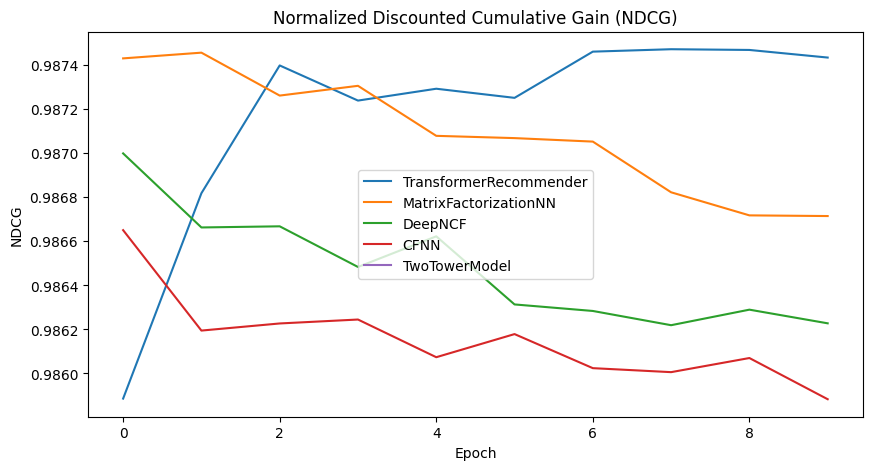

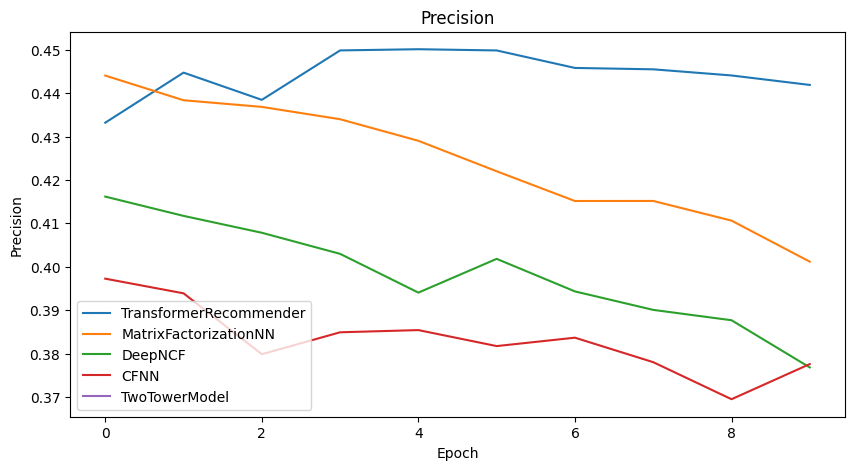

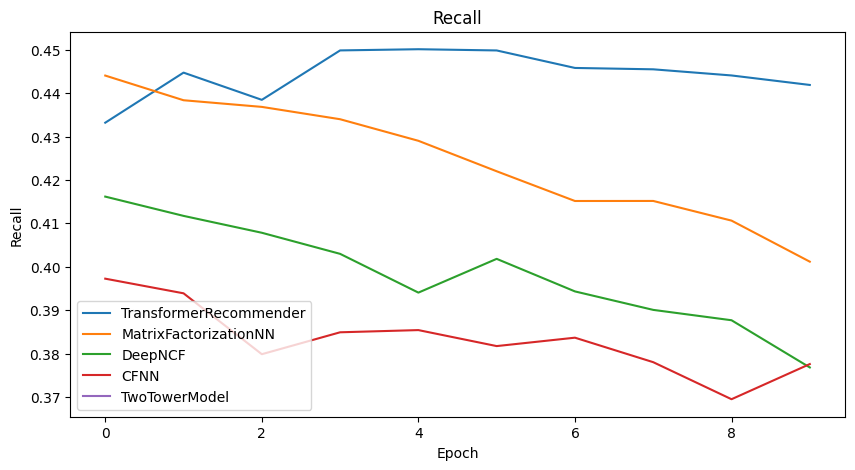

In [71]:
def plot_metrics(history, title, ylabel):
    plt.figure(figsize=(10, 5))
    for model_name, values in history.items():
        plt.plot(values, label=model_name)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# Plot training and evaluation losses
plot_metrics(train_loss_history, 'Training Loss', 'Loss')
plot_metrics(eval_loss_history, 'Evaluation Loss', 'Loss')

# Plot evaluation metrics
plot_metrics(mse_history, 'Mean Squared Error (MSE)', 'MSE')
plot_metrics(mae_history, 'Mean Absolute Error (MAE)', 'MAE')
plot_metrics(ndcg_history, 'Normalized Discounted Cumulative Gain (NDCG)', 'NDCG')
plot_metrics(precision_history, 'Precision', 'Precision')
plot_metrics(recall_history, 'Recall', 'Recall')

In [ ]:
# MF with ALS
import implicit
import scipy.sparse as sp
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, ndcg_score, precision_score

# Ensure that userId and movieId are sequentially numbered
data_with_tags['user_index'] = data_with_tags['userId'].astype("category").cat.codes
data_with_tags['movie_index'] = data_with_tags['movieId'].astype("category").cat.codes

# Prepare the data for ALS model
sparse_user_item = pd.DataFrame({
    "user_index": data_with_tags['user_index'],
    "movie_index": data_with_tags['movie_index'],
    "rating": data_with_tags['rating_normalized']
})

# Convert to a sparse matrix
user_item_matrix = sp.coo_matrix(
    (sparse_user_item['rating'], (sparse_user_item['user_index'], sparse_user_item['movie_index']))
)

# Initialize the ALS model
als_model = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20)

# Train the ALS model
als_model.fit(user_item_matrix.T)  # Implicit expects items x users matrix

# Define a function to get recommendations
def als_recommend(user_id, model, user_item_matrix, N=10):
    user_items = user_item_matrix.T.tocsr()
    if user_id < model.user_factors.shape[0]:  # Ensure user_id is within bounds
        recommendations = model.recommend(user_id, user_items, N, filter_already_liked_items=False)
        return [item[0] for item in recommendations]
    else:
        return []

# Evaluate the ALS model
def evaluate_als_model(test_data, als_model, user_item_matrix, N=10):
    all_targets = []
    all_preds = []
    for user_id in test_data['user_index'].unique():
        user_test_data = test_data[test_data['user_index'] == user_id]
        true_movie_ids = user_test_data['movie_index'].tolist()
        pred_movie_ids = als_recommend(user_id, als_model, user_item_matrix, N)

        # Create binary relevance scores for NDCG and precision calculation
        relevance = [1 if movie_id in true_movie_ids else 0 for movie_id in pred_movie_ids]

        # Ensure consistent lengths for all_targets and all_preds
        target_length = min(len(true_movie_ids), N)
        all_targets.extend([1] * target_length + [0] * (N - target_length))
        all_preds.extend(relevance[:N])

    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    ndcg = ndcg_score([all_targets], [all_preds])
    precision = precision_score(all_targets, all_preds, average='micro', zero_division=0)

    return mse, mae, ndcg, precision

# Split data into train and test sets
train_data, test_data = train_test_split(data_with_tags, test_size=0.2, random_state=42)

# Evaluate ALS model
mse, mae, ndcg, precision = evaluate_als_model(test_data, als_model, user_item_matrix)
print(f"ALS Model - MSE: {mse}, MAE: {mae}, NDCG: {ndcg}, Precision: {precision}")


/usr/local/lib/python3.10/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.20163464546203613 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]